# Object Detection

[Detectron2](https://detectron2.readthedocs.io/en/latest/) is a platform for object detection, segmentation and other visual recognition tasks.

* Includes new capabilities such as panoptic segmentation, Densepose, Cascade R-CNN, rotated bounding boxes, PointRend, DeepLab, ViTDet, MViTv2 etc.
* Used as a library to support building research projects on top of it.
* Models can be exported to TorchScript format or Caffe2 format for deployment.

In [ ]:
!pip install opencv-python matplotlib

In [ ]:
!python -m pip install 'git+https://github.com/facebookresearch/detectron2.git'

## Detectron2 :: Faster RCNN R101 FPN

In [1]:
import detectron2

#https://github.com/facebookresearch/detectron2/blob/main/MODEL_ZOO.md
from detectron2 import model_zoo
from detectron2.data import DatasetCatalog, build_detection_test_loader
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.engine import DefaultTrainer, DefaultPredictor
from detectron2.config import get_cfg
from detectron2.structures import BoxMode
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog

import matplotlib.pyplot as plt
import numpy as np
import torch, os, json, cv2, random

In [2]:
# Setup detectron2 logger
from detectron2.utils.logger import setup_logger
setup_logger()

<Logger detectron2 (DEBUG)>

In [3]:
CLASS_LABELS = ["balloon"]

### Custom Dataset

* [Balloon Dataset](https://github.com/matterport/Mask_RCNN/releases/download/v2.1/balloon_dataset.zip)

In [4]:
dataset_path = '../datasets/balloon/'

In [13]:
# # if your dataset is in COCO format:
# from detectron2.data.datasets import register_coco_instances
# register_coco_instances("dataset_train", {}, "../datasets/balloon/train/via_region_data.json", "../datasets/balloon/train/")
# register_coco_instances("dataset_val", {}, "../datasets/balloon/val/via_region_data.json", "../datasets/balloon/val/")

In [5]:
def get_ds_dicts(dataset_path):
    json_file = os.path.join(dataset_path, "via_region_data.json")
    
    with open(json_file) as f:
        imgs_anns = json.load(f)

    dataset_dicts = []

    for idx, v in enumerate(imgs_anns.values()):
        record = {}
        filename = os.path.join(dataset_path, v["filename"])
        height, width = cv2.imread(filename).shape[:2]
        
        record["file_name"] = filename
        record["image_id"] = idx
        record["height"] = height
        record["width"] = width

        annos = v["regions"]
        objs = []

        for _, anno in annos.items():
            assert not anno["region_attributes"]
            anno = anno["shape_attributes"]
            px = anno["all_points_x"]
            py = anno["all_points_y"]
            poly = [(x + 0.5, y + 0.5) for x, y in zip(px, py)]
            poly = [p for x in poly for p in x]

            obj = {
                "bbox": [np.min(px), np.min(py), np.max(px), np.max(py)],
                "bbox_mode": BoxMode.XYXY_ABS,
                "segmentation": [poly],
                "category_id": 0,
            }

            objs.append(obj)

        record["annotations"] = objs
        dataset_dicts.append(record)

    return dataset_dicts

In [6]:
for d in ["train", "val"]:
    DatasetCatalog.register("balloon_" + d, lambda d=d: get_ds_dicts(dataset_path + d))
    MetadataCatalog.get("balloon_" + d).set(thing_classes=CLASS_LABELS)

In [9]:
metadata = MetadataCatalog.get("balloon_train")

In [10]:
dataset_dicts = get_ds_dicts(dataset_path + "train")

In [19]:
dataset_dicts[0]["file_name"]

'../datasets/balloon/train/34020010494_e5cb88e1c4_k.jpg'

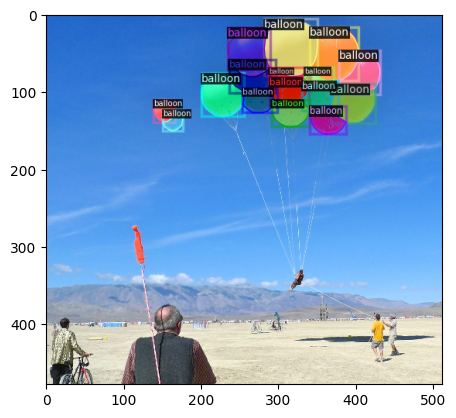

In [22]:
for d in random.sample(dataset_dicts, 1):
    img = plt.imread(d["file_name"])
    # plt.imshow(img)
    visualizer = Visualizer(img[:, :, ::-1], metadata=metadata, scale=0.5)
    out = visualizer.draw_dataset_dict(d)
    plt.imshow(out.get_image()[:, :, ::-1])

## Model Training

In [24]:
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_R_101_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("balloon_train",)
cfg.DATASETS.TEST = ()
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Detection/faster_rcnn_R_101_FPN_3x.yaml")  # initialize from model zoo
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.BASE_LR = 0.00025
cfg.SOLVER.MAX_ITER = 500
cfg.SOLVER.STEPS = []  # do not decay learning rate
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128 # faster, and good enough for this toy dataset
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1  # only has one class (ballon)

In [25]:
os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)

trainer = DefaultTrainer(cfg)
trainer.resume_or_load(resume=False)

[08/26 10:42:51 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

model_final_f6e8b1.pkl: 243MB [00:37, 6.46MB/s]                                                                                                        
Skip loading parameter 'roi_heads.box_predictor.cls_score.weight' to the model due to incompatible shapes: (81, 1024) in the checkpoint but (2, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.cls_score.bias' to the model due to incompatible shapes: (81,) in the checkpoint but (2,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.weight' to the model due to incompatible shapes: (320, 1024) in the checkpoint but (4, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.bias' to the model due to incompatible shapes: (320,) in the checkpoint but (4,) in the model! You might want to double check if this is expected.
Some m

In [26]:
trainer.train()

[08/26 10:43:41 d2.engine.train_loop]: Starting training from iteration 0


/opt/conda/lib/python3.10/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /opt/conda/conda-bld/pytorch_1682343967769/work/aten/src/ATen/native/TensorShape.cpp:3483.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


[08/26 10:44:02 d2.utils.events]:  eta: 0:06:34  iter: 19  total_loss: 1.412  loss_cls: 0.7343  loss_box_reg: 0.6371  loss_rpn_cls: 0.0313  loss_rpn_loc: 0.01339    time: 0.8252  last_time: 0.7575  data_time: 0.0196  last_data_time: 0.0023   lr: 9.7405e-06  max_mem: 3497M
[08/26 10:44:19 d2.utils.events]:  eta: 0:06:20  iter: 39  total_loss: 1.347  loss_cls: 0.6506  loss_box_reg: 0.6581  loss_rpn_cls: 0.0346  loss_rpn_loc: 0.01007    time: 0.8276  last_time: 0.7039  data_time: 0.0033  last_data_time: 0.0032   lr: 1.9731e-05  max_mem: 3497M
[08/26 10:44:35 d2.utils.events]:  eta: 0:06:05  iter: 59  total_loss: 1.167  loss_cls: 0.5208  loss_box_reg: 0.5955  loss_rpn_cls: 0.02241  loss_rpn_loc: 0.006228    time: 0.8246  last_time: 0.6293  data_time: 0.0032  last_data_time: 0.0031   lr: 2.972e-05  max_mem: 3497M
[08/26 10:44:52 d2.utils.events]:  eta: 0:05:47  iter: 79  total_loss: 1.154  loss_cls: 0.43  loss_box_reg: 0.6943  loss_rpn_cls: 0.02387  loss_rpn_loc: 0.007003    time: 0.8296  l

* iter: 499  total_loss: 0.1755  loss_cls: 0.0539  loss_box_reg: 0.1116  loss_rpn_cls: 0.007705  loss_rpn_loc: 0.003967    time: 0.8457  last_time: 0.8804  data_time: 0.0034  last_data_time: 0.0020   lr: 0.0002495  max_mem: 3624M
* Overall training speed: 498 iterations in 0:07:01 (0.8457 s / it)
* Total training time: 0:07:10 (0:00:09 on hooks)

### Inference & Evaluation

In [ ]:
%load_ext tensorboard
%tensorboard --logdir output

![Detectron2 :: Faster RCNN R101 FPN](./assets/Object_Detection_Detectron2_04.webp)

In [28]:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7   # set the testing threshold for this model
cfg.DATASETS.TEST = ("balloon_val", )
predictor = DefaultPredictor(cfg)

[08/26 10:52:54 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from ./output/model_final.pth ...


In [42]:
dataset_dicts = get_ds_dicts(dataset_path + "val")

In [ ]:
plt.figure(figsize=(14, 10))

c = 1

for i in random.sample(dataset_dicts, 4):
    im = cv2.imread(i["file_name"])
    outputs = predictor(im)

    v = Visualizer(im[:, :, ::-1], metadata=metadata, scale=0.8)
    v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    
    ax = plt.subplot(2, 2, c)
    plt.imshow(cv2.cvtColor(v.get_image()[:, :, ::-1], cv2.COLOR_BGR2RGB))
    plt.axis("off")

    c += 1

plt.savefig("./assets/Object_Detection_Detectron2_03.webp", bbox_inches='tight')

![Detectron2 :: Faster RCNN R101 FPN](./assets/Object_Detection_Detectron2_03.webp)

In [ ]:
evaluator = COCOEvaluator("balloon_val", ("bbox",), False, output_dir="./output/")
val_loader = build_detection_test_loader(cfg, "balloon_val")

print(inference_on_dataset(trainer.model, val_loader, evaluator))

|  |  |  |  |
| -- | -- | -- | -- |
| Average Precision | (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.767 |
| Average Precision | (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.921 |
| Average Precision | (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.844 |
| Average Precision | (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.184 |
| Average Precision | (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.591 |
| Average Precision | (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.902 |
| Average Recall | (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.242 |
| Average Recall | (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.786 |
| Average Recall | (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.808 |
| Average Recall | (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.467 |
| Average Recall | (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.659 |
| Average Recall | (AR) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.927 |

Evaluation results for bbox: 
|   AP   |  AP50  |  AP75  |  APs   |  APm   |  APl   |
|:------:|:------:|:------:|:------:|:------:|:------:|
| 76.726 | 92.089 | 84.378 | 18.366 | 59.092 | 90.191 |